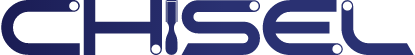

## Chisel Running Enviroments


In [ ]:
import $ivy.`edu.berkeley.cs::chisel3:3.1.0` 
import $ivy.`edu.berkeley.cs::chisel-iotesters:1.2.0`     

In [ ]:
import chisel3._
import chisel3.util._
import chisel3.iotesters.{ChiselFlatSpec, Driver, PeekPokeTester}

### Utils Wrapper Function for Jupyter
- getVerilog
- getFirrtl
- compileFIRRTL
- stringifyAST

In [ ]:
// Convenience function to invoke Chisel and grab emitted Verilog.
def getVerilog(dut: => chisel3.core.UserModule): String = {
  import firrtl._
  return chisel3.Driver.execute(Array[String](), {() => dut}) match {
    case s:chisel3.ChiselExecutionSuccess => s.firrtlResultOption match {
      case Some(f:FirrtlExecutionSuccess) => f.emitted
    }
  }
}

// Convenience function to invoke Chisel and grab emitted FIRRTL.
def getFirrtl(dut: => chisel3.core.UserModule): String = {
  return chisel3.Driver.emit({() => dut})
}

def compileFIRRTL(
    inputFirrtl: String,
    compiler: firrtl.Compiler,
    customTransforms: Seq[firrtl.Transform] = Seq.empty,
    infoMode: firrtl.Parser.InfoMode = firrtl.Parser.IgnoreInfo,
    annotations: firrtl.AnnotationSeq = firrtl.AnnotationSeq(Seq.empty)
): String = {
  import firrtl.{Compiler, AnnotationSeq, CircuitState, ChirrtlForm, FIRRTLException}
  import firrtl.Parser._
  import scala.io.Source
  import scala.util.control.ControlThrowable
  import firrtl.passes._
  val outputBuffer = new java.io.CharArrayWriter
  try {
      //val parsedInput = firrtl.Parser.parse(Source.fromFile(input).getLines(), infoMode)
      val parsedInput = firrtl.Parser.parse(inputFirrtl.split("\n").toIterator, infoMode)
      compiler.compile(
         CircuitState(parsedInput, ChirrtlForm, annotations),
         outputBuffer,
         customTransforms)
  }

  catch {
    // Rethrow the exceptions which are expected or due to the runtime environment (out of memory, stack overflow)
    case p: ControlThrowable => throw p
    case p: PassException  => throw p
    case p: FIRRTLException => throw p
     // Treat remaining exceptions as internal errors.
       case e: Exception => firrtl.Utils.throwInternalError(exception = Some(e))
  }

  val outputString = outputBuffer.toString
  outputString
}

def stringifyAST(firrtlAST: firrtl.ir.Circuit): String = {
  var ntabs = 0
  val buf = new StringBuilder
  val string = firrtlAST.toString
  string.zipWithIndex.foreach { case (c, idx) =>
    c match {
      case ' ' =>
      case '(' =>
        ntabs += 1
        buf ++= "(\n" + "| " * ntabs
      case ')' =>
        ntabs -= 1
        buf ++= "\n" + "| " * ntabs + ")"
      case ','=> buf ++= ",\n" + "| " * ntabs
      case  c if idx > 0 && string(idx-1)==')' =>
        buf ++= "\n" + "| " * ntabs + c
      case c => buf += c
    }
  }
  buf.toString
}   

# Your First Module

In [ ]:
class PassThrough extends Module{
  val io = IO(new Bundle{
    val in = Input(UInt(8.W))
    val out = Output(UInt(8.W))
  })
  io.in := io.out
} 
println(getVerilog(new Passthrough))